# Model Training With Synthetic Patterns

by Victor Hugo Flores Muñoz

In [1]:
from IPython import display
from sklearn.utils import shuffle
from tensorflow.python.ops.numpy_ops import np_config
from zernike import RZern
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import time

2024-10-02 11:44:35.897785: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-02 11:44:35.941655: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 11:44:35.941690: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 11:44:35.941721: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 11:44:35.951948: I tensorflow/core/platform/cpu_feature_g

Define Helpers

In [2]:
def normaliza(A):
    mask = np.isnan(A)
    B = np.nan_to_num(A, nan=0)
    C = (B - B.min())/(B.max() - B.min()) * 2 - 1
    C[mask] = 0.0
    return C

def normaliza_zernike(y): #JV
    ymax = np.max(y,axis=0)
    ymin = np.min(y,axis=0)
    ynorm = (y-ymin)/(ymax-ymin)
    return ynorm, ymax, ymin

def denormaliza_zernike(ynorm, ymax, ymin): #JV
    y = ynorm*(ymax-ymin)+ymin 
    return y

def normaliza_pos(A):
    mask = np.isnan(A)
    B = np.nan_to_num(A, nan=0)
    C = B
    C = (B - B.min())/(B.max() - B.min())
    C[mask] = 0.0
    return C

def generate_mask(reference):
    mask = np.isnan(reference)
    mask = np.logical_not(mask)
    return mask

Define constants and parameters for the zernike generator.

In [3]:
HEIGHT = 128 #256 JV
WIDTH = 128  #256 JV
cart = RZern(2)
ddx = np.linspace(-1.0, 1.0, WIDTH)
ddy = np.linspace(-1.0, 1.0, HEIGHT)
xv, yv = np.meshgrid(ddx, ddy)
cart.make_cart_grid(xv, yv)
num_coef = cart.nk
print("Number of coefficients ", num_coef)
Phi = cart.eval_grid(np.array([0,1,0,0,0,0]), matrix=True)
MASK = generate_mask(Phi)

Number of coefficients  6


## 1. Dataset Generation

In [4]:
def GeneradorZ(num_samples=50000, num_coef=10, h=256, w=256):
    y = np.empty((num_samples, num_coef))
    X = np.empty((num_samples, h, w))
    Xcos = np.empty((num_samples, h, w))
    for k in range(num_samples):
        y[k] = [
            random.random() * 20 - 10,
            random.random() * 30 - 15,
            random.random() * 30 - 15,
            random.random() * 30 - 15,
            random.random() * 30 - 15,
            random.random() * 30 - 15
        ]
        Phi = cart.eval_grid(y[k], matrix=True)
        X[k,:,:] = normaliza_pos(Phi)
        Xcos[k,:,:] = normaliza_pos(np.cos(Phi))
    return X, y, Xcos

def GeneradorZ_sparse(num_samples=50000, num_coef=10, h=256, w=256):
    y = np.empty((num_samples,num_coef))
    X = np.empty((num_samples, h, w))
    Xcos = np.empty((num_samples, h, w))
    for k in range(num_samples):
        y[k] = np.zeros(num_coef)
        n_terms = np.random.randint(1,num_coef)
        for cont in range(n_terms):
            index = np.random.randint(num_coef)
            if index == 0:
                y[k, index] = random.random() * 20 - 10
            else:
                y[k, index] = random.random() * 30 - 15
        Phi = cart.eval_grid(y[k], matrix=True)
        X[k,:,:] = normaliza_pos(Phi)
        Xcos[k,:,:] = normaliza_pos(np.cos(Phi))
    return X, y, Xcos

Generate the dataset with 10000 samples:

`X` are the phases

`y` are the coefficients

`Xcos` are the cosine function of the phases

In [5]:
NUM_SAMPLES = 15000 #35000 JV

X1, y1, Xcos1 = GeneradorZ(num_samples=NUM_SAMPLES//2, 
                           num_coef=num_coef, 
                           h=HEIGHT, 
                           w=WIDTH)
X2, y2, Xcos2 = GeneradorZ_sparse(num_samples=NUM_SAMPLES//2, 
                                  num_coef=num_coef, 
                                  h=HEIGHT, 
                                  w=WIDTH)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, y2))
y,ymax,ymin = normaliza_zernike(y) #JV
Xcos = np.concatenate((Xcos1, Xcos2))

Create train, validation and test datasets.

In [6]:
num_samples_train = round(NUM_SAMPLES * .9)
X, y, Xcos= shuffle(X, y, Xcos)
X_train = np.expand_dims(X[:num_samples_train], axis=3)
X_train_cos = np.expand_dims(Xcos[:num_samples_train], axis=3)
y_train = y[:num_samples_train]
X_test = np.expand_dims(X[num_samples_train:], axis=3)
X_test_cos = np.expand_dims(Xcos[num_samples_train:], axis=3)
y_test = y[num_samples_train:]

BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_cos, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_cos, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)
validation_split = 0.1
num_samples = len(train_dataset)
num_train = round(num_samples * (1 - validation_split))
train_ds = train_dataset.take(num_train).batch(BATCH_SIZE)
val_dataset = train_dataset.skip(num_train).batch(BATCH_SIZE)

2024-10-02 11:44:58.918083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22447 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-10-02 11:44:58.918754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22447 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:5e:00.0, compute capability: 8.6
2024-10-02 11:44:58.919227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22447 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:86:00.0, compute capability: 8.6
2024-10-02 11:44:58.919698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21903 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

## 2. Create Model

### 2.1 AutoEncoder

In [8]:
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()

    result.add(
        tf.keras.layers.Conv2D(
            filters,
            size,
            padding='same',
            kernel_initializer=initializer
        )
    )
    
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            4,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False
        )
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    
    result = tf.keras.Sequential()
    
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            4,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False
        )
    )

    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            padding='same',
            kernel_initializer=initializer
        )
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.LeakyReLU())
        
    return result

def Encoder(attention=False):
    #inputs = tf.keras.layers.Input(shape=[256, 256, 1]) #JV
    inputs = tf.keras.layers.Input(shape=[128, 128, 1]) #JV

    down_stack = [
        downsample(16, 3), # (bs, 128, 128, 16)
        downsample(32, 3), # (bs, 64, 64, 32)
        downsample(64, 3), # (bs, 32, 32, 64)
        downsample(128, 3), # (bs, 16, 16, 128)Max-Pool
        downsample(256, 3), # (bs, 8, 8, 256)
        downsample(256, 3), # (bs, 4, 4, 256)
        downsample(512, 3), # (bs, 2, 2, 512) #JV
    ]

    x = inputs

    # Downsampling through the model
    for down in down_stack:
        x = down(x)
        [height, width, chan] = x.shape[1:]
        if attention:
            # Attention to layers 32 to 8
            if height <= 32 and height >= 8:
                x = tf.reshape(x, [-1, height*width, chan])
                x = tf.keras.layers.Attention()([x, x])
                x = tf.reshape(x, [-1, height, width, chan])
    latent_space_dim = (x.shape)[1:]
    x = tf.keras.layers.Flatten()(x)
    return tf.keras.Model(inputs=inputs, outputs=x, name='encoder'), latent_space_dim

def Decoder(latent_space_dim):

    inputs = tf.keras.layers.Input(shape=(np.prod(latent_space_dim),))
    inputs_reshaped = tf.keras.layers.Reshape(target_shape=(latent_space_dim))(inputs)

    up_stack =[ 
        upsample(512, 3), # (bs, 4, 4, 256)
        upsample(256, 3), # (bs, 8, 8, 256)
        upsample(256, 3), # (bs, 16, 16, 128)
        upsample(128, 3), # (bs, 32, 32, 64)
        upsample(64, 3), # (bs, 64, 64, 32)
        upsample(32, 3), # (bs, 128, 128, 16)
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)

    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS,
        kernel_size=4,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='relu'
    )

    x = inputs_reshaped

    for up in up_stack:
        x = up(x)
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name='decoder')

encoder, latent_space_dim = Encoder(attention=False)
decoder = Decoder(latent_space_dim)

print("JV")
print(latent_space_dim)

JV
(1, 1, 512)


### 2.2 Loss Function of the Autoencoder

In [9]:
loss_object = tf.keras.losses.MeanSquaredError()

LAMBDA = 100 #JV

def ae_loss(y_true, y_pred):
    return LAMBDA * loss_object(y_true,  y_pred) 

### 2.3 Dense Neural Network

To estimate the Zernike coefficients

In [10]:
def latent_decoder(latent_space_dim):

    dense_input = tf.keras.layers.Input(shape=(np.prod(latent_space_dim),), name="dense_input")

    D1 = tf.keras.layers.Dense(np.prod(latent_space_dim))(dense_input)
    D1 = tf.keras.layers.BatchNormalization()(D1)
    D1 = tf.keras.activations.tanh(D1)

    D2 = tf.keras.layers.Dense(1024)(D1)
    D2 = tf.keras.layers.BatchNormalization()(D2)
    D2 = tf.keras.activations.tanh(D2)

    D3 = tf.keras.layers.Dense(512)(D2)
    D3 = tf.keras.layers.BatchNormalization()(D3)
    D3 = tf.keras.activations.tanh(D3)

    D4 = tf.keras.layers.Dense(256)(D3)
    D4 = tf.keras.layers.BatchNormalization()(D4)
    D4 = tf.keras.activations.tanh(D4)

    D5 = tf.keras.layers.Dense(128)(D4)
    D5 = tf.keras.layers.BatchNormalization()(D5)
    D5 = tf.keras.activations.tanh(D5)

    D6 = tf.keras.layers.Dense(64)(D5)
    D6 = tf.keras.layers.BatchNormalization()(D6)
    D6 = tf.keras.activations.tanh(D6)

    D7 = tf.keras.layers.Dense(32)(D6)
    D7 = tf.keras.layers.BatchNormalization()(D7)
    last = tf.keras.layers.Dense(6)(D7)

    return tf.keras.Model(inputs=dense_input, outputs=last, name='latent_decoder')

zernike_decoder = latent_decoder(latent_space_dim)

### 2.4 Zernike Decoder Loss

In [11]:
LAMBDA = 10
ALPHA = 1

loss_object_zernike = tf.keras.losses.MeanAbsoluteError()
loss_object_phase = tf.keras.losses.MeanAbsoluteError()

def generate_zernike(coef, normalize=True):
    #coef[0] = 0
    Phi = cart.eval_grid(coef, matrix=True)
    if normalize:
        Phi = normaliza_pos(Phi)
    return Phi

def zernike2phi(coef):
    # Phi = tf.map_fn(generate_zernike, coef)
    Phi = tf.map_fn(
        lambda x: generate_zernike(x, normalize=False),
        coef
    )
    B = np.nan_to_num(Phi, nan=0)
    return B

def zernike2cos(coef):
    Phi = tf.map_fn(
        lambda x: generate_zernike(x, normalize=False),
        coef
    )
    Phi = tf.math.cos(Phi)
    B = np.nan_to_num(Phi, nan=0)
    return B

def zernike2gradient(coef):
    Phi = tf.map_fn(
        lambda x: generate_zernike(x, normalize=False),
        coef
    )
    Phi = tf.convert_to_tensor(
        np.expand_dims(
            np.nan_to_num(Phi), 
            axis=3
        )
    )
    dx, dy = tf.image.image_gradients(Phi)
    return dx, dy

def cos_loss(y_true, y_pred):
    phi = zernike2cos(y_true)
    hat_phi = zernike2cos(y_pred)
    return LAMBDA * loss_object_phase(phi, hat_phi)

#def phase_loss(y_true, y_pred):
#    phi = zernike2phi(y_true)
#    hat_phi = zernike2phi(y_pred)
#    return ALPHA * loss_object_phase(phi, hat_phi) #JV: incluyo LAMBDA


def phase_loss(y_true, y_pred): #JV
    # Crear una máscara que establece el primer elemento de cada fila a cero
    mask = tf.concat([tf.zeros((1, 1), dtype=y_true.dtype), 
                      tf.ones((y_true.shape[0] - 1, 1), dtype=y_true.dtype)], axis=0)
    
    # Aplicar la máscara multiplicando elemento a elemento
    y_true_masked = y_true * mask
    y_pred_masked = y_pred * mask

    # Convertir los coeficientes Zernike en fases ópticas
    phi = zernike2phi(y_true_masked)
    hat_phi = zernike2phi(y_pred_masked)

    # Calcular la pérdida utilizando la función de pérdida de fases
    #l1 = ALPHA * LAMBDA * loss_object_phase(phi, hat_phi)
    #l2 = ALPHA * LAMBDA * loss_object_phase(phi, -hat_phi)
    l1 = ALPHA * loss_object_phase(phi, hat_phi)
    l2 = ALPHA * loss_object_phase(phi, -hat_phi)

    # Usar tf.where para decidir cuál pérdida usar basada en la magnitud
    loss = tf.where(tf.abs(l1) < tf.abs(l2), l1, l2)
    return loss
    
def grad_loss(y_true, y_pred):
    dx_true, dy_true = zernike2gradient(y_true)
    dx_pred, dy_pred = zernike2gradient(y_pred)
    return LAMBDA * (0.5*loss_object(dx_true, dx_pred) + 0.5*loss_object(dy_true, dy_pred))


#def zernike_loss(y_true, y_pred):
#    y_true[0] = 0
#    y_pred[0] = 0
#    l1 = ALPHA * loss_object_zernike(y_true, y_pred)
#    l2 = ALPHA * loss_object_zernike(y_true, (-1)*y_pred)
#    if abs(l1) < abs(l2):
#        loss = l1
#    else:
#        loss = l2
#        
#    return loss

def zernike_loss(y_true, y_pred): #JV
    # Crear una máscara que pone a cero el primer elemento de cada fila
    mask = tf.concat([tf.zeros((y_true.shape[0], 1), dtype=y_true.dtype),
                      tf.ones((y_true.shape[0], y_true.shape[1] - 1), dtype=y_true.dtype)], axis=1)

    # Aplicar la máscara a y_true y y_pred
    y_true_updated = y_true * mask
    y_pred_updated = y_pred * mask

    # Calcular las pérdidas con los tensores actualizados
    l1 = ALPHA * loss_object_zernike(y_true_updated, y_pred_updated)
    l2 = ALPHA * loss_object_zernike(y_true_updated, -y_pred_updated)

    # Usar tf.where para decidir cuál pérdida usar basada en la magnitud
    loss = tf.where(tf.abs(l1) < tf.abs(l2), l1, l2)

    return loss

def total_zernike_loss(y_true, y_pred):
    #return zernike_loss(y_true, y_pred)
    return phase_loss(y_true, y_pred) + grad_loss(y_true, y_pred) + zernike_loss(y_true, y_pred)   #JV quito toda la mierda


## 3. Training The Autoencoder

### 3.1 Optimizers And Utilities

In [12]:
autoencoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
zernike_decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

def generate_images(models, test_input, tar):

    encoder = models[0]
    decoder = models[1]
    zernike_decoder = models[2]

    encoded_image = encoder(test_input, training=True)
    prediction = decoder(encoded_image, training=True)
    zernikes = zernike_decoder(encoded_image, training=True)

    generated_zernike = np.nan_to_num(
        generate_zernike(zernikes[0].numpy(), normalize=False), 
        nan=0
    )
    
    got = np.nan_to_num(
        generate_zernike(tar[0].numpy(), normalize=False),
        nan=0
    )
    error = np.abs(got - generated_zernike)    
    plt.figure(figsize=(25,15))

    display_list = [test_input[0], prediction[0], np.cos(generated_zernike), np.cos(got), error]
    
    title = [
        'Input Image', 
        'Autoencoder', 
        np.round(zernikes[0].numpy(), decimals=2), 
        np.round(tar[0].numpy(), decimals=2),
        'Phase Error'
    ]
    
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i])
        plt.colorbar(fraction=0.046)
        plt.axis('off')
    plt.show()

### 3.2 Autoencoder: Training Step and Fit Functions

In [13]:
@tf.function()
def train_step_ae(input_image):
    with tf.GradientTape() as autoencoder_tape:
        encoded_image = encoder(input_image, training=True)
        decoded_image = decoder(encoded_image, training=True)

        autoencoder_loss = ae_loss(input_image, decoded_image)

    autoencoder_gradients = autoencoder_tape.gradient(
        autoencoder_loss, 
        encoder.trainable_variables + decoder.trainable_variables
    )

    autoencoder_optimizer.apply_gradients(zip(
        autoencoder_gradients, 
        encoder.trainable_variables + decoder.trainable_variables
    ))
    
    return autoencoder_loss

@tf.function()
def validation_step_ae(input_image):
    encoded_image = encoder(input_image, training=False)
    decoded_image = decoder(encoded_image, training=False)
    autoencoder_loss = ae_loss(input_image, decoded_image)
    return autoencoder_loss

def plot_graphs_ae(record, epoch):
    x = range(epoch)
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('autoencoder_loss')
    ax1.plot(x, record['autoencoder_loss'], label='training_loss', color='tab:red')
    ax1.plot(x, record['validation_loss'], label='validation_loss', color='tab:blue')
    ax1.tick_params(axis='y')

    fig.tight_layout()
    plt.show()

def fit_ae(train_ds, val_ds, test_ds, epochs):

    record = {
        'autoencoder_loss': [],
        'validation_loss': []
    }

    example_input, example_target = next(iter(test_ds.take(1)))
    
    for epoch in range(epochs):

        start = time.time()
        print("Epoch: ", epoch)

        n = 0
        for input_image, target in train_ds:
            autoencoder_loss = train_step_ae(input_image)
            if n % 10 == 0:
                print('.', end='')
            n += 1
        
        for input_image, target in val_ds:
            validation_loss = validation_step_ae(input_image)
        
        display.clear_output(wait=True)
        generate_images([encoder, decoder, zernike_decoder], 
                        example_input, 
                        example_target)
        
        record['autoencoder_loss'].append(autoencoder_loss.numpy())
        record['validation_loss'].append(validation_loss.numpy())
        plot_graphs_ae(record, epoch + 1)

        print("Time taken: ", time.time() - start)
        print("Autoencoder Loss: ", autoencoder_loss.numpy())
        
    return record

### 3.3 Autoencoder: Training

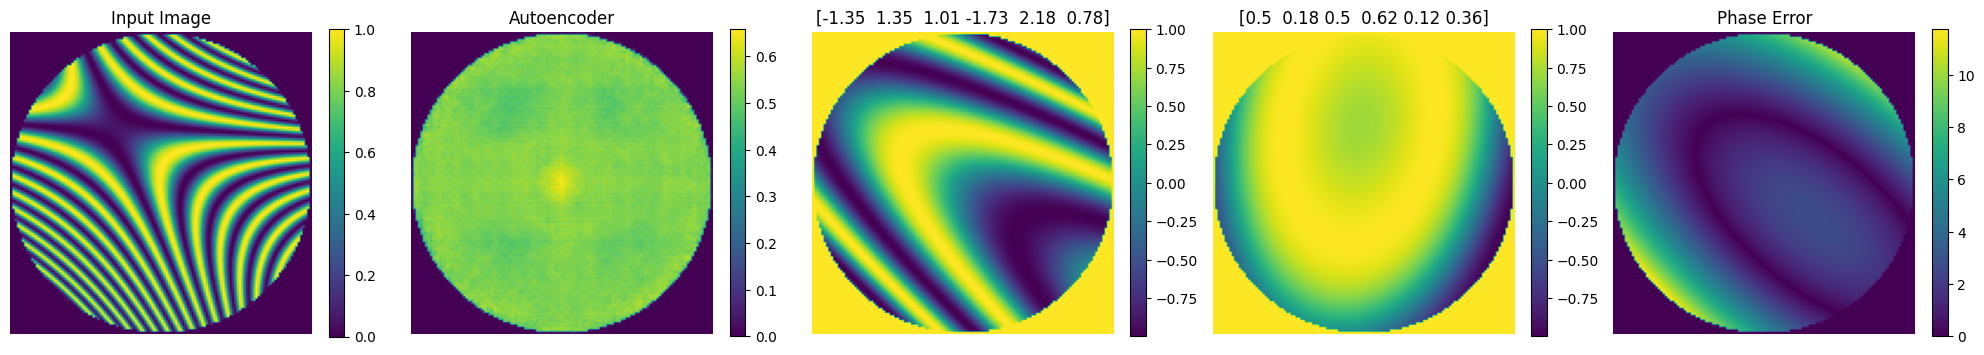

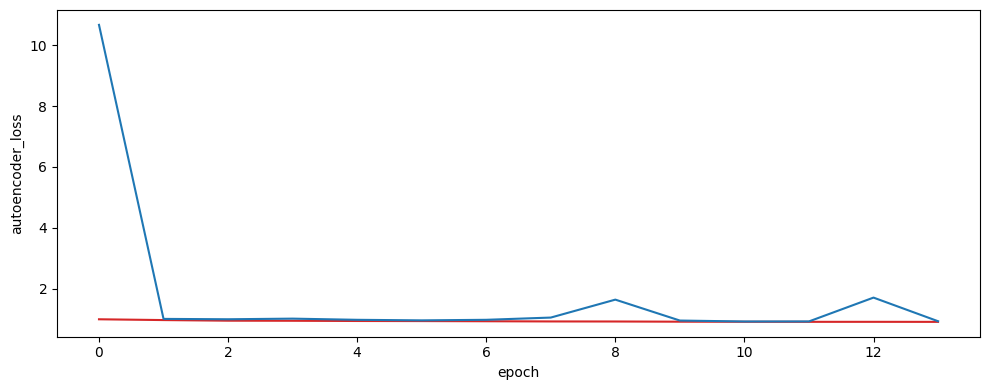

Time taken:  6.53097677230835
Autoencoder Loss:  0.9123052
Epoch:  14
.

In [ ]:
EPOCHS = 200
record = fit_ae(train_ds, val_dataset, test_dataset, epochs=EPOCHS)

### 3.4 Autoencoder: Evaluate the results

In [ ]:
autoencoder = tf.keras.models.Model(
    inputs=encoder.inputs, 
    outputs=decoder(encoder.outputs)
)
autoencoder.compile(optimizer=autoencoder_optimizer, 
                    loss=ae_loss)
autoencoder.evaluate(X_test_cos, X_test_cos)

## 4. Training The Zernike Decoder

The encoder model can be trained with the autoencoder or loaded from the saved models.

### 4.1 Zernike Decoder: Training Step and Fit Functions

In [ ]:
#@tf.function()
#def train_step_zae(input_image, target):
#    with tf.GradientTape() as zernike_decoder_tape:
#        encoded_image = encoder(input_image)
#        zernikes = zernike_decoder(encoded_image, training=True)#
#
#        # Loss calculation
#        zernike_decoder_loss = zernike_loss(target, zernikes)
#        estimated_phase_loss = phase_loss(target, zernikes)       
#        estimated_grad_loss =  grad_loss(target, zernikes)
#
#        # Total loss
#        total_zernike_decoder_loss = (zernike_decoder_loss +\
#                                    estimated_phase_loss + \
#                                    estimated_grad_loss)
#
#    zernike_decoder_gradients = zernike_decoder_tape.gradient(
#        total_zernike_decoder_loss, 
#        zernike_decoder.trainable_variables
#    )
#    
#    zernike_decoder_optimizer.apply_gradients(zip(
#        zernike_decoder_gradients, 
#        zernike_decoder.trainable_variables
#    )) 
#
#    return [zernike_decoder_loss, 
#            estimated_phase_loss, 
#            estimated_grad_loss]

@tf.function()
def train_step_zae(input_image, target):
    with tf.GradientTape() as zernike_decoder_tape:
        encoded_image = encoder(input_image)
        zernikes = zernike_decoder(encoded_image, training=True)

        # Loss calculation
        zernike_decoder_loss = zernike_loss(target, zernikes)
        estimated_phase_loss = phase_loss(target, zernikes)       
        estimated_grad_loss =  grad_loss(target, zernikes)

        # Total loss
        total_zernike_decoder_loss = (zernike_decoder_loss +\
                                    estimated_phase_loss + \
                                    estimated_grad_loss)
        
    
    zernike_decoder_gradients = zernike_decoder_tape.gradient(
        total_zernike_decoder_loss, 
        zernike_decoder.trainable_variables
    )
    
    zernike_decoder_optimizer.apply_gradients(zip(
        zernike_decoder_gradients, 
        zernike_decoder.trainable_variables
    ))

    #zernike_decoder_loss = zernike_decoder_loss*0
    #estimated_phase_loss = zernike_decoder_loss*0
    #estimated_grad_loss = zernike_decoder_loss*0
    
    return [zernike_decoder_loss, 
            estimated_phase_loss, 
            estimated_grad_loss]

def plot_graphs_zae(record, epoch):
    x = range(epoch)
    fig, ax1 = plt.subplots(figsize=(10,4))
    color = 'tab:red'
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('total_zernike_decoder_loss', color=color)
    ax1.plot(x, record['total_zernike_decoder_loss'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('training time', color=color)
    ax2.plot(x, record['time'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()


def fit_zae(train_ds, test_ds, epochs):
    # tf.compat.v1.enable_eager_execution()

    record = {
        'zernike_decoder_loss': [],
        'estimated_phase_loss': [],
        'estimated_grad_loss': [],
        'total_zernike_decoder_loss': [], 
        'time': []
    }

    example_input, example_target = next(iter(test_ds.take(1)))
    
    for epoch in range(epochs):

        start = time.time()
        print("Epoch: ", epoch + 1)

        n = 0
        for input_image, target in train_ds:
            zernike_decoder_loss = train_step_zae(input_image,
                                                  target)
            if n % 10 == 0:
                print('··', end='')
            n += 1
        
        display.clear_output(wait=True)
        generate_images([encoder, decoder, zernike_decoder], 
                        example_input, 
                        example_target)
        
        record['zernike_decoder_loss'].append(zernike_decoder_loss[0].numpy())
        record['estimated_phase_loss'].append(zernike_decoder_loss[1].numpy())
        record['estimated_grad_loss'].append(zernike_decoder_loss[2].numpy())
        record['total_zernike_decoder_loss'].append(
            zernike_decoder_loss[0].numpy() + \
            zernike_decoder_loss[1].numpy() + \
            zernike_decoder_loss[2].numpy()
        )
        delta_time = time.time() - start
        record['time'].append(delta_time)

        plot_graphs_zae(record, epoch + 1)

        print("Time taken: ", delta_time)
        print("Zernike Decoder Loss: ", zernike_decoder_loss[0].numpy())
        print("Estimated Phase Loss: ", zernike_decoder_loss[1].numpy())
        print("Estimated Gradient Loss: ", zernike_decoder_loss[2].numpy())
        print("Total Zernike Decoder Loss: ", 
              zernike_decoder_loss[0].numpy() + \
              zernike_decoder_loss[1].numpy() + \
              zernike_decoder_loss[2].numpy())

    return record

### 4.2 Zernike Decoder: Training

In [ ]:
EPOCHS = 100
np_config.enable_numpy_behavior()
tf.config.run_functions_eagerly(True)
record = fit_zae(train_ds, test_dataset, epochs=EPOCHS)

## 5. Results

### 5.1 Save models and metrics

In [ ]:
import pickle
import os

os.makedirs('../data', exist_ok=True)
with open('../data/record.pkl', 'wb') as f:
    pickle.dump(record, f)

zernike_decoder.save('../models/zae_zernike_decoder_vargas.h5')
encoder.save('../models/ae_encoder_vargas.h5')
decoder.save('../models/ae_decoder_vargas.h5')

### 5.2 Load Trained Models for Testing

In [ ]:
def model_loader(path, optimizer, loss):
    model = tf.keras.models.load_model(path, compile=False)
    model.compile(optimizer=optimizer, 
                  loss=loss)
    return model

#encoder = model_loader('../models/ae_encoder.h5',
#                       autoencoder_optimizer,
#                       ae_loss)
#decoder = model_loader('../models/ae_decoder.h5',
#                       autoencoder_optimizer,
#                       ae_loss)

#zernike_decoder = model_loader('../models/zae_zernike_decoder.h5',
#                               zernike_decoder_optimizer,
#                               total_zernike_loss)

encoder = model_loader('../models/ae_encoder_vargas.h5',
                       autoencoder_optimizer,
                       ae_loss)
decoder = model_loader('../models/ae_decoder_vargas.h5',
                       autoencoder_optimizer,
                       ae_loss)

zernike_decoder = model_loader('../models/zae_zernike_decoder_vargas.h5',
                               zernike_decoder_optimizer,
                               total_zernike_loss)

In [ ]:
zautoencoder = tf.keras.models.Model(
    inputs=encoder.inputs, 
    outputs=zernike_decoder(encoder.outputs)
)
zautoencoder.compile(optimizer=zernike_decoder_optimizer, 
                     loss=total_zernike_loss)
zautoencoder.evaluate(X_test_cos, y_test)

5.3 Sample Results

In [ ]:
num = 10

example_input, example_target = next(iter(test_dataset.take(num)))
zernike_coefs = zautoencoder.predict(example_input)
generated_zernike = zernike2phi(zernike_coefs)
generated_zernike_cos = zernike2cos(zernike_coefs)
real_zernike = zernike2phi(example_target)

plt.figure(figsize=(15,15))

for i in range(num):
    plt.subplot(num, 4, 4*i+1)
    plt.imshow(example_input[i])
    plt.title("Input Image")
    plt.axis('off')
    plt.subplot(num, 4, 4*i+2)
    plt.imshow(generated_zernike_cos[i])
    plt.title("Generated Zernike Cos")
    plt.axis('off')
    plt.subplot(num, 4, 4*i+3)
    plt.imshow(real_zernike[i])
    plt.title("Real Zernike")
    plt.colorbar()
    plt.axis('off')
    plt.subplot(num, 4, 4*i+4)
    plt.imshow(generated_zernike[i])
    plt.title("Generated Zernike")
    plt.colorbar()
    plt.axis('off')